# This code uses periodicity from a recording as a song detector.

### It saves a .json file with all of the file names, file paths, and the time segments of detected songs. Next, it saves .npz files for each .wav file containing its hyperparameters, log amplitude traces, amplitude trace of oscillations, the power of the filtered spectrogram, and the smoothed power.

# This is the full periodicity song detector for ONE .wav file (adjust file_path in line 192 to visualize a different .wav file's calculations):

The screen resolution in inches is: 15.12x9.82


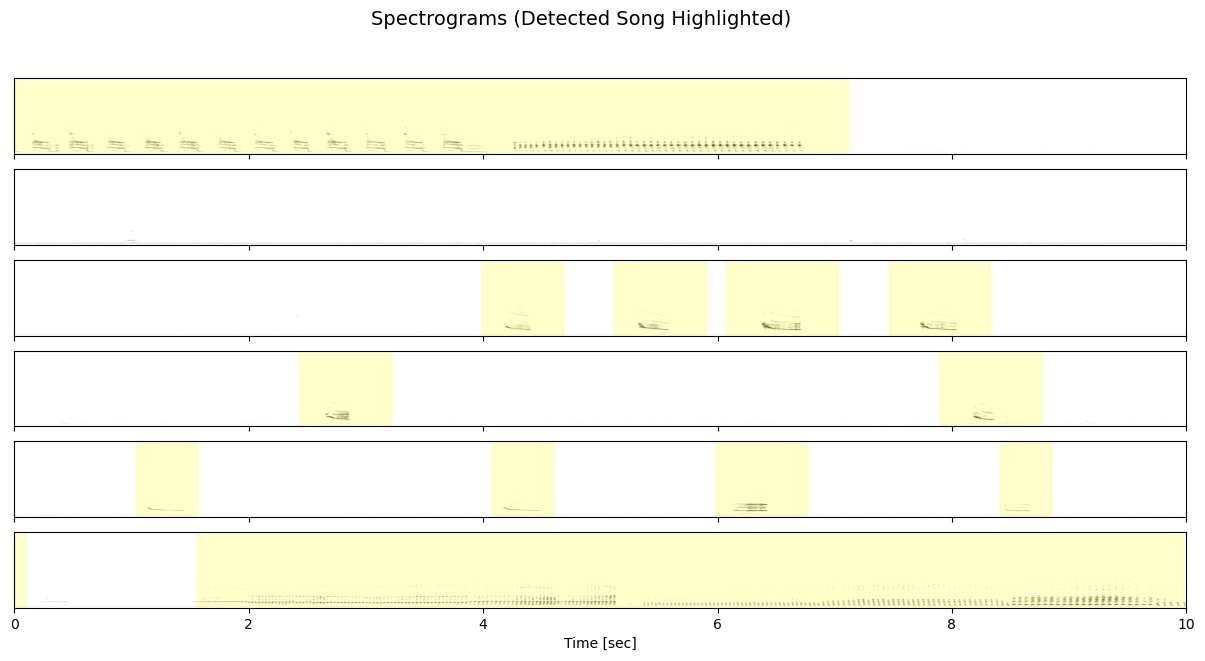

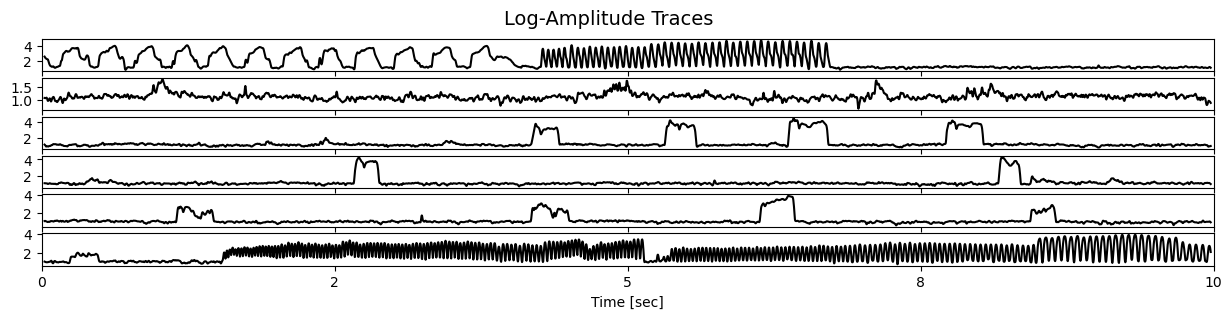

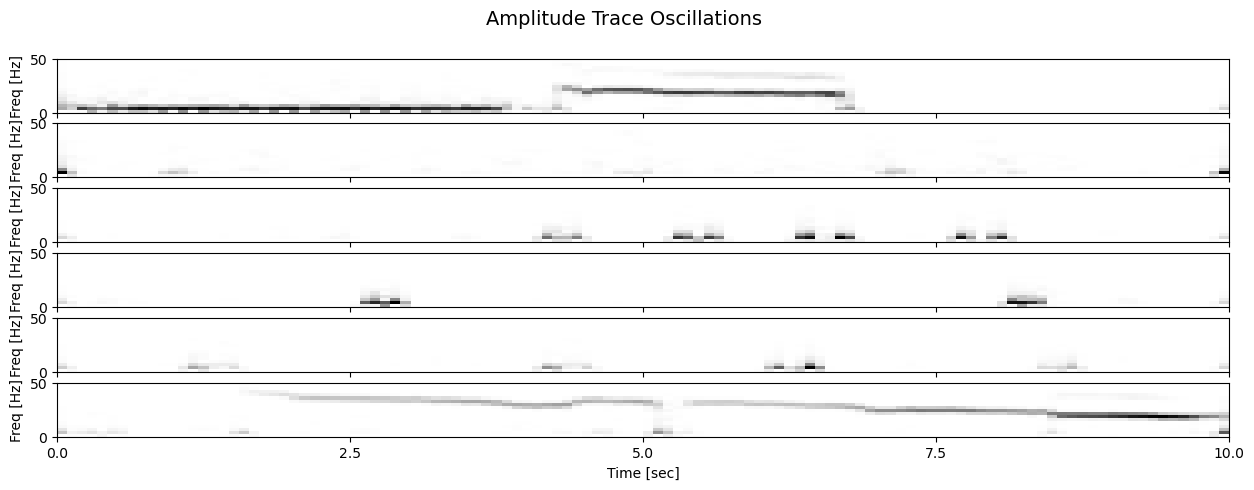

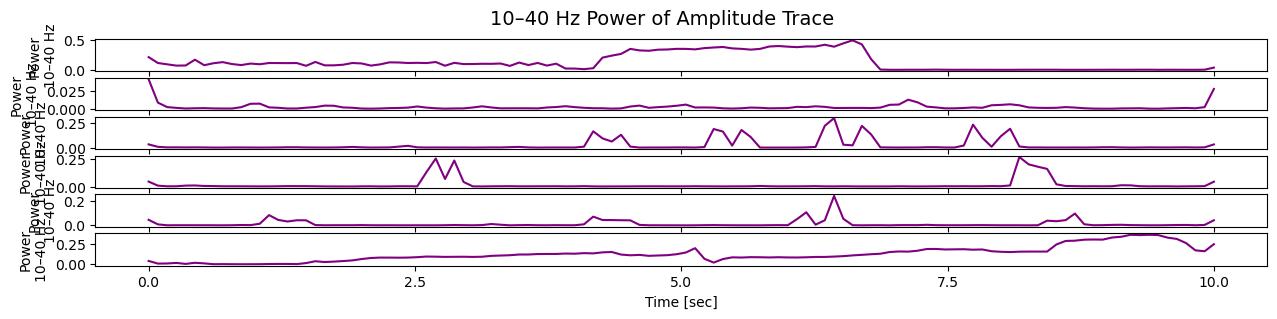

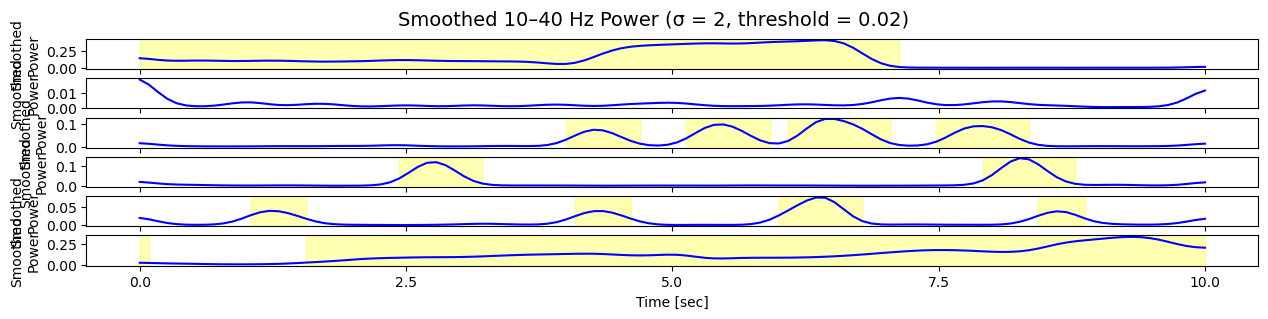

In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk

# === Get screen resolution in inches (for figure sizing) ===
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # assuming 100 dpi

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

# === Main Function ===
def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000,
                                  smoothing_sigma=3, power_threshold=0.5):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig3, axs_amp_spec = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.5), sharex=True)
        fig4, axs_power_band = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        fig5, axs_smoothed_power = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)

        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]
            axs_amp_spec = [axs_amp_spec]
            axs_power_band = [axs_power_band]
            axs_smoothed_power = [axs_smoothed_power]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # === Spectrogram of segment ===
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Log-Amplitude trace from summed power ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

            axs_sum[i].plot(t, log_amplitude_trace, color='black')
            axs_sum[i].set_xlim(0, 10)

            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])

            # === Spectrogram of log-amplitude trace with full padding ===
            amp_fs = len(t) / segment_duration
            nperseg = 128
            pad_len = nperseg // 2
            expected_length = int(segment_duration * amp_fs)

            pad_start = pad_len
            pad_end = expected_length + pad_len - len(log_amplitude_trace)
            if pad_end < 0:
                pad_end = 0

            padded_log_trace = np.pad(log_amplitude_trace, (pad_start, pad_end), mode='constant')

            f_amp, t_amp_raw, Sxx_amp = spectrogram(
                padded_log_trace,
                fs=amp_fs,
                window='hann',
                nperseg=nperseg,
                noverlap=96
            )
            t_amp = t_amp_raw - (nperseg / 2) / amp_fs  # Shift to align first window center to 0s

            axs_amp_spec[i].imshow(Sxx_amp, aspect='auto', origin='lower',
                                   extent=[t_amp.min(), t_amp.max(), f_amp.min(), f_amp.max()],
                                   cmap='binary')
            axs_amp_spec[i].set_ylim(0, 50)
            axs_amp_spec[i].set_xlim(t_amp.min(), t_amp.max())
            axs_amp_spec[i].set_ylabel('Freq [Hz]')

            if i == num_segments - 1:
                axs_amp_spec[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(t_amp.min(), t_amp.max(), 5)
                axs_amp_spec[i].set_xticks(tick_positions)
                axs_amp_spec[i].set_xticklabels([f"{val:.1f}" for val in tick_positions])
            else:
                axs_amp_spec[i].set_xticks([])

            # === Bandpassed Power trace in Hz ===
            band_mask = (f_amp >= 5) & (f_amp <= 50)
            band_power = np.sum(Sxx_amp[band_mask, :], axis=0)
            axs_power_band[i].plot(t_amp, band_power, color='purple')
            axs_power_band[i].set_ylabel('Power\n10–40 Hz')

            if i == num_segments - 1:
                axs_power_band[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(t_amp.min(), t_amp.max(), 5)
                axs_power_band[i].set_xticks(tick_positions)
                axs_power_band[i].set_xticklabels([f"{val:.1f}" for val in tick_positions])
            else:
                axs_power_band[i].set_xticks([])

            # === Smoothed Bandpassed Power and Detected Song ===
            smoothed_power = gaussian_filter1d(band_power, sigma=smoothing_sigma)
            axs_smoothed_power[i].plot(t_amp, smoothed_power, color='blue')
            axs_smoothed_power[i].set_ylabel('Smoothed\nPower')

            above_thresh = smoothed_power > power_threshold
            if np.any(above_thresh):
                in_segment = False
                for j in range(len(above_thresh)):
                    if above_thresh[j] and not in_segment:
                        in_segment = True
                        start_time = t_amp[j]
                    elif not above_thresh[j] and in_segment:
                        end_time = t_amp[j]
                        axs_smoothed_power[i].axvspan(start_time, end_time, color='yellow', alpha=0.3)
                        axs[i].axvspan(start_time, end_time, color='yellow', alpha=0.2)
                        in_segment = False
                if in_segment:
                    axs_smoothed_power[i].axvspan(start_time, t_amp[-1], color='yellow', alpha=0.3)
                    axs[i].axvspan(start_time, t_amp[-1], color='yellow', alpha=0.2)

            if i == num_segments - 1:
                axs_smoothed_power[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(t_amp.min(), t_amp.max(), 5)
                axs_smoothed_power[i].set_xticks(tick_positions)
                axs_smoothed_power[i].set_xticklabels([f"{val:.1f}" for val in tick_positions])
            else:
                axs_smoothed_power[i].set_xticks([])

        fig1.suptitle('Spectrograms (Detected Song Highlighted)', fontsize=14)
        fig2.suptitle('Log-Amplitude Traces', fontsize=14)
        fig3.suptitle('Amplitude Trace Oscillations', fontsize=14)
        fig4.suptitle('10–40 Hz Power of Amplitude Trace', fontsize=14)
        fig5.suptitle(f'Smoothed 10–40 Hz Power (σ = {smoothing_sigma}, threshold = {power_threshold})', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === Run the Function ===
#file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_detected_song_files_full_recordings/detected_song_minute_4.wav'
plot_spectrograms_by_segment(file_path, smoothing_sigma=2, power_threshold=0.02)

# older version from periodicity_song_detector_full_pipeline that takes in a folder path, then saves a .json file with the file names and the time segments of detected songs inside:

In [2]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import os
import json

def detect_song_intervals(file_path, segment_duration=10, low_cut=500, high_cut=8000,
                          smoothing_sigma=3, power_threshold=0.5):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        detected_intervals = []

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = min(start_sample + segment_length_samples, len(data))
            segment_data = data[start_sample:end_sample]

            if len(segment_data) < segment_length_samples:
                # Pad the last segment
                padded = np.zeros(segment_length_samples, dtype=segment_data.dtype)
                padded[:len(segment_data)] = segment_data
                segment_data = padded

            # Spectrogram
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048 / 8),
                nperseg=2048,
                noverlap=2048 - 119
            )

            freq_mask = (f >= low_cut) & (f <= high_cut)
            amplitude_trace = np.sum(Sxx[freq_mask, :], axis=0)
            log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

            # Pad amplitude trace for spectrogram
            amp_fs = len(t) / segment_duration
            nperseg = 128
            pad_len = nperseg // 2
            expected_length = int(segment_duration * amp_fs)

            pad_start = pad_len
            pad_end = expected_length + pad_len - len(log_amplitude_trace)
            if pad_end < 0:
                pad_end = 0
            padded_trace = np.pad(log_amplitude_trace, (pad_start, pad_end), mode='constant')

            f_amp, t_amp_raw, Sxx_amp = spectrogram(
                padded_trace,
                fs=amp_fs,
                window='hann',
                nperseg=nperseg,
                noverlap=96
            )
            t_amp = t_amp_raw - (nperseg / 2) / amp_fs

            band_mask = (f_amp >= 10) & (f_amp <= 40)
            band_power = np.sum(Sxx_amp[band_mask, :], axis=0)
            smoothed_power = gaussian_filter1d(band_power, sigma=smoothing_sigma)

            # Detect song segments
            above_thresh = smoothed_power > power_threshold
            in_segment = False
            segment_start = 0

            for j, is_above in enumerate(above_thresh):
                current_time = t_amp[j] + i * segment_duration
                if is_above and not in_segment:
                    in_segment = True
                    segment_start = current_time
                elif not is_above and in_segment:
                    segment_end = current_time
                    detected_intervals.append([segment_start, segment_end])
                    in_segment = False

            if in_segment:
                segment_end = t_amp[-1] + i * segment_duration
                detected_intervals.append([segment_start, segment_end])

        return detected_intervals

    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return []

def process_folder(folder_path, output_json_path, **kwargs):
    results = {}

    for fname in sorted(os.listdir(folder_path)):
        if fname.lower().endswith(".wav"):
            file_path = os.path.join(folder_path, fname)
            print(f"Processing: {fname}")
            intervals = detect_song_intervals(file_path, **kwargs)
            results[fname] = intervals

    with open(output_json_path, 'w') as f:
        json.dump(results, f, indent=4)

    print(f"\nSaved song detection results to: {output_json_path}")

# === Example usage ===
folder_path = "/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55"
output_json_path = folder_path + f"_ampltidue_only_detected_song_intervals.json"

process_folder(
    folder_path,
    output_json_path,
    segment_duration=10,
    low_cut=500,
    high_cut=8000,
    smoothing_sigma=5,
    power_threshold=0.13
)

Processing: USA5510_45755.22382904_4_8_6_13_2.wav
Processing: USA5510_45755.23801765_4_8_6_36_41.wav
Processing: USA5510_45755.24425276_4_8_6_47_5.wav
Processing: USA5510_45755.25551217_4_8_7_5_51.wav
Processing: USA5510_45755.25568837_4_8_7_6_8.wav
Processing: USA5510_45755.25604998_4_8_7_6_44.wav
Processing: USA5510_45755.25619988_4_8_7_6_59.wav
Processing: USA5510_45755.25666577_4_8_7_7_46.wav
Processing: USA5510_45755.25701628_4_8_7_8_21.wav
Processing: USA5510_45755.25756457_4_8_7_9_16.wav
Processing: USA5510_45755.25771625_4_8_7_9_31.wav
Processing: USA5510_45755.25778467_4_8_7_9_38.wav
Processing: USA5510_45755.25804229_4_8_7_10_4.wav
Processing: USA5510_45755.25849428_4_8_7_10_49.wav
Processing: USA5510_45755.25887979_4_8_7_11_27.wav
Processing: USA5510_45755.25895867_4_8_7_11_35.wav
Processing: USA5510_45755.25958997_4_8_7_12_38.wav
Processing: USA5510_45755.25993310_4_8_7_13_13.wav
Processing: USA5510_45755.26006037_4_8_7_13_26.wav
Processing: USA5510_45755.26030477_4_8_7_13_

# BAD NEWER VERSION THAT DOES NOT WORK!!!

In [ ]:
# import numpy as np
# import os
# import json
# from pathlib import Path
# from scipy.io import wavfile
# from scipy.signal import spectrogram, windows, ellip, filtfilt
# from scipy.ndimage import gaussian_filter1d
# from tqdm import tqdm


# def detect_song_from_amplitude(file_path, output_npz_folder,
#                                 segment_duration=10,
#                                 audio_low_cut=500, audio_high_cut=8000,
#                                 modulation_low_cut=10, modulation_high_cut=40,
#                                 smoothing_sigma=3, power_threshold=0.5,
#                                 save_spectrograms=False):
#     try:
#         samplerate, data = wavfile.read(file_path)
#         if data.ndim > 1:
#             data = data.mean(axis=1)

#         nyquist = samplerate / 2
#         wp = [audio_low_cut / nyquist, audio_high_cut / nyquist]
#         b, a = ellip(5, 0.2, 40, wp, btype='band')
#         data = filtfilt(b, a, data)

#         segment_length_samples = int(segment_duration * samplerate)
#         num_segments = int(np.ceil(len(data) / segment_length_samples))

#         detected_segments = []
#         all_log_amplitude_trace = []
#         all_oscillatory_power = []
#         all_smoothed_power = []

#         last_Sxx = last_f = last_t = None
#         last_Sxx_amp = last_f_amp = last_t_amp = None

#         for i in range(num_segments):
#             start_sample = i * segment_length_samples
#             end_sample = min(start_sample + segment_length_samples, len(data))
#             segment_data = data[start_sample:end_sample]

#             if len(segment_data) < segment_length_samples:
#                 padded = np.zeros(segment_length_samples, dtype=segment_data.dtype)
#                 padded[:len(segment_data)] = segment_data
#                 segment_data = padded

#             f, t, Sxx = spectrogram(
#                 segment_data,
#                 fs=samplerate,
#                 window=windows.gaussian(2048, std=2048 / 8),
#                 nperseg=2048,
#                 noverlap=2048 - 119
#             )

#             freq_mask = (f >= audio_low_cut) & (f <= audio_high_cut)
#             amplitude_trace = np.sum(Sxx[freq_mask, :], axis=0)
#             log_amplitude_trace = np.log10(amplitude_trace + np.finfo(float).eps)

#             amp_fs = len(t) / segment_duration
#             nperseg = 128
#             pad_len = nperseg // 2
#             expected_length = int(segment_duration * amp_fs)

#             pad_start = pad_len
#             pad_end = expected_length + pad_len - len(log_amplitude_trace)
#             pad_end = max(pad_end, 0)
#             padded_trace = np.pad(log_amplitude_trace, (pad_start, pad_end), mode='constant')

#             f_amp, t_amp_raw, Sxx_amp = spectrogram(
#                 padded_trace,
#                 fs=amp_fs,
#                 window='hann',
#                 nperseg=nperseg,
#                 noverlap=96
#             )
#             t_amp = t_amp_raw - (nperseg / 2) / amp_fs

#             band_mask = (f_amp >= modulation_low_cut) & (f_amp <= modulation_high_cut)
#             band_power = np.sum(Sxx_amp[band_mask, :], axis=0)
#             smoothed_power = gaussian_filter1d(band_power, sigma=smoothing_sigma)

#             all_log_amplitude_trace.extend(log_amplitude_trace)
#             all_oscillatory_power.extend(band_power)
#             all_smoothed_power.extend(smoothed_power)

#             above_thresh = smoothed_power > power_threshold
#             in_segment = False
#             segment_start = 0

#             for j, is_above in enumerate(above_thresh):
#                 current_time = t_amp[j] + i * segment_duration
#                 if is_above and not in_segment:
#                     in_segment = True
#                     segment_start = current_time
#                 elif not is_above and in_segment:
#                     segment_end = current_time
#                     detected_segments.append([float(segment_start), float(segment_end)])
#                     in_segment = False

#             if in_segment:
#                 segment_end = t_amp[-1] + i * segment_duration
#                 detected_segments.append([float(segment_start), float(segment_end)])

#             # Save last spectrograms (only one example per file)
#             last_Sxx, last_f, last_t = Sxx, f, t
#             last_Sxx_amp, last_f_amp, last_t_amp = Sxx_amp, f_amp, t_amp

#         save_dict = dict(
#             log_amplitude_trace=np.array(all_log_amplitude_trace),
#             oscillatory_power=np.array(all_oscillatory_power),
#             smoothed_power=np.array(all_smoothed_power),
#             audio_bandpass_low_cut=audio_low_cut,
#             audio_bandpass_high_cut=audio_high_cut,
#             modulation_bandpass_low_cut=modulation_low_cut,
#             modulation_bandpass_high_cut=modulation_high_cut,
#             Gaussian_smoothing_sigma=smoothing_sigma,
#             amplitude_power_threshold=power_threshold,
#             segment_duration=segment_duration
#         )

#         if save_spectrograms:
#             save_dict.update(
#                 audio_spectrogram=last_Sxx,
#                 audio_frequencies=last_f,
#                 audio_times=last_t,
#                 modulation_spectrogram=last_Sxx_amp,
#                 modulation_frequencies=last_f_amp,
#                 modulation_times=last_t_amp
#             )

#         base_name = Path(file_path).stem
#         npz_path = os.path.join(output_npz_folder, f"{base_name}_amplitude_modulation_traces.npz")
#         np.savez(npz_path, **save_dict)

#         return {
#             "file_name": Path(file_path).name,
#             "file_path": str(Path(file_path).resolve()),
#             "detected_segments": detected_segments
#         }

#     except Exception as e:
#         print(f"❌ Error processing {file_path}: {e}")
#         return None


# def process_folder_with_detailed_outputs(folder_path,
#                                          segment_duration=10,
#                                          audio_low_cut=500, audio_high_cut=8000,
#                                          modulation_low_cut=10, modulation_high_cut=40,
#                                          smoothing_sigma=3, power_threshold=0.5,
#                                          save_spectrograms=False):

#     folder_path = Path(folder_path)
#     parent_dir = folder_path.parent
#     folder_name = folder_path.name
#     output_folder = parent_dir / f"{folder_name}_amplitude_modulation_detection_outputs"
#     npz_folder = output_folder / "npz_traces"
#     os.makedirs(npz_folder, exist_ok=True)

#     metadata = []
#     wav_files = sorted([f for f in folder_path.iterdir() if f.suffix.lower() == '.wav'])

#     for file_path in tqdm(wav_files, desc="Processing .wav files", unit="file"):
#         info = detect_song_from_amplitude(
#             file_path,
#             output_npz_folder=npz_folder,
#             segment_duration=segment_duration,
#             audio_low_cut=audio_low_cut,
#             audio_high_cut=audio_high_cut,
#             modulation_low_cut=modulation_low_cut,
#             modulation_high_cut=modulation_high_cut,
#             smoothing_sigma=smoothing_sigma,
#             power_threshold=power_threshold,
#             save_spectrograms=save_spectrograms
#         )
#         if info:
#             metadata.append(info)

#     json_path = output_folder / "detected_song_segments.json"
#     with open(json_path, "w") as f:
#         json.dump(metadata, f, indent=4)

#     print(f"\n✅ Saved JSON metadata: {json_path}")
#     print(f"✅ Saved .npz traces in: {npz_folder}/")


In [ ]:
# # === USER SETUP ===
# folder_path = '//Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55'

# process_folder_with_detailed_outputs(
#     folder_path,
#     segment_duration=10,
#     audio_low_cut=500,
#     audio_high_cut=8000,
#     modulation_low_cut=10,
#     modulation_high_cut=40,
#     smoothing_sigma=5,
#     power_threshold=0.13,
#     save_spectrograms=True  # 👈 Toggle this ON/OFF
# )

Processing .wav files: 100%|██████████| 200/200 [01:28<00:00,  2.25file/s]


✅ Saved JSON metadata: //Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_amplitude_modulation_detection_outputs/detected_song_segments.json
✅ Saved .npz traces in: //Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_amplitude_modulation_detection_outputs/npz_traces/


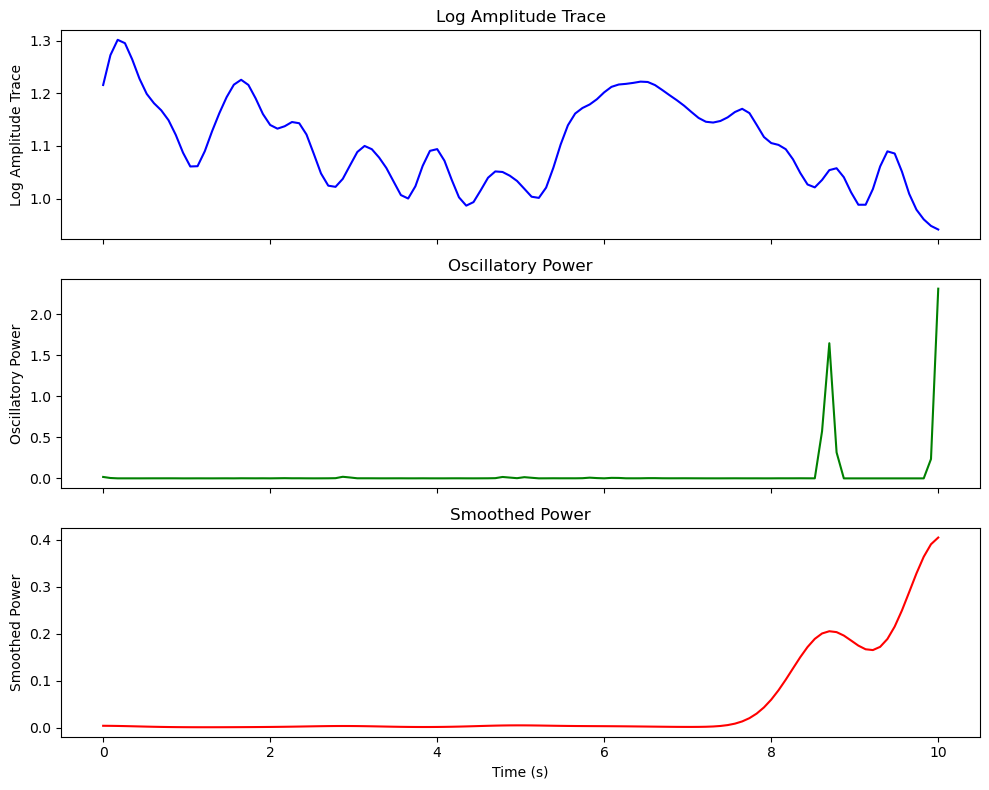

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt

# def plot_npz_data(npz_filename):
#     try:
#         # Load the .npz file
#         npz_data = np.load(npz_filename)

#         # Extract data from the .npz file
#         log_amplitude_trace = npz_data['log_amplitude_trace']
#         oscillatory_power = npz_data['oscillatory_power']
#         smoothed_power = npz_data['smoothed_power']

#         # Time for the log_amplitude_trace assuming it spans the whole segment duration
#         segment_duration = npz_data['segment_duration']
#         time_log_amplitude = np.linspace(0, segment_duration * len(log_amplitude_trace) / len(oscillatory_power), len(log_amplitude_trace))

#         # Time for oscillatory_power and smoothed_power
#         time_power = np.linspace(0, segment_duration, len(oscillatory_power))

#         # Interpolation to align log_amplitude_trace with the time for oscillatory_power
#         log_amplitude_trace_resampled = np.interp(time_power, time_log_amplitude, log_amplitude_trace)

#         # Create the figure and axes
#         fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)

#         # Plot Log Amplitude Trace
#         axes[0].plot(time_power, log_amplitude_trace_resampled, color='blue')
#         axes[0].set_ylabel('Log Amplitude Trace')
#         axes[0].set_title('Log Amplitude Trace')

#         # Plot Oscillatory Power
#         axes[1].plot(time_power, oscillatory_power, color='green')
#         axes[1].set_ylabel('Oscillatory Power')
#         axes[1].set_title('Oscillatory Power')

#         # Plot Smoothed Power
#         axes[2].plot(time_power, smoothed_power, color='red')
#         axes[2].set_ylabel('Smoothed Power')
#         axes[2].set_title('Smoothed Power')
#         axes[2].set_xlabel('Time (s)')

#         plt.tight_layout()
#         plt.show()

#     except Exception as e:
#         print(f"❌ Error processing {npz_filename}: {e}")

# # Example usage:
# npz_filename = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5510_unsegmented_songs/55_amplitude_modulation_detection_outputs/npz_traces/USA5510_45755.22382904_4_8_6_13_2_amplitude_modulation_traces.npz'
# plot_npz_data(npz_filename)
